In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

%matplotlib inline
import random
import matplotlib.pyplot as plt

## About Dataset
### Context
MNIST is a subset of a larger set available from NIST (it's copied from http://yann.lecun.com/exdb/mnist/)

### Content
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .
Four files are available:  


* train-images-idx3-ubyte.gz: training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

In [25]:

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [26]:
#
# Set file paths based on added MNIST Datasets
#
input_path = './archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [27]:
#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


In [28]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [30]:
y_train[0]

5

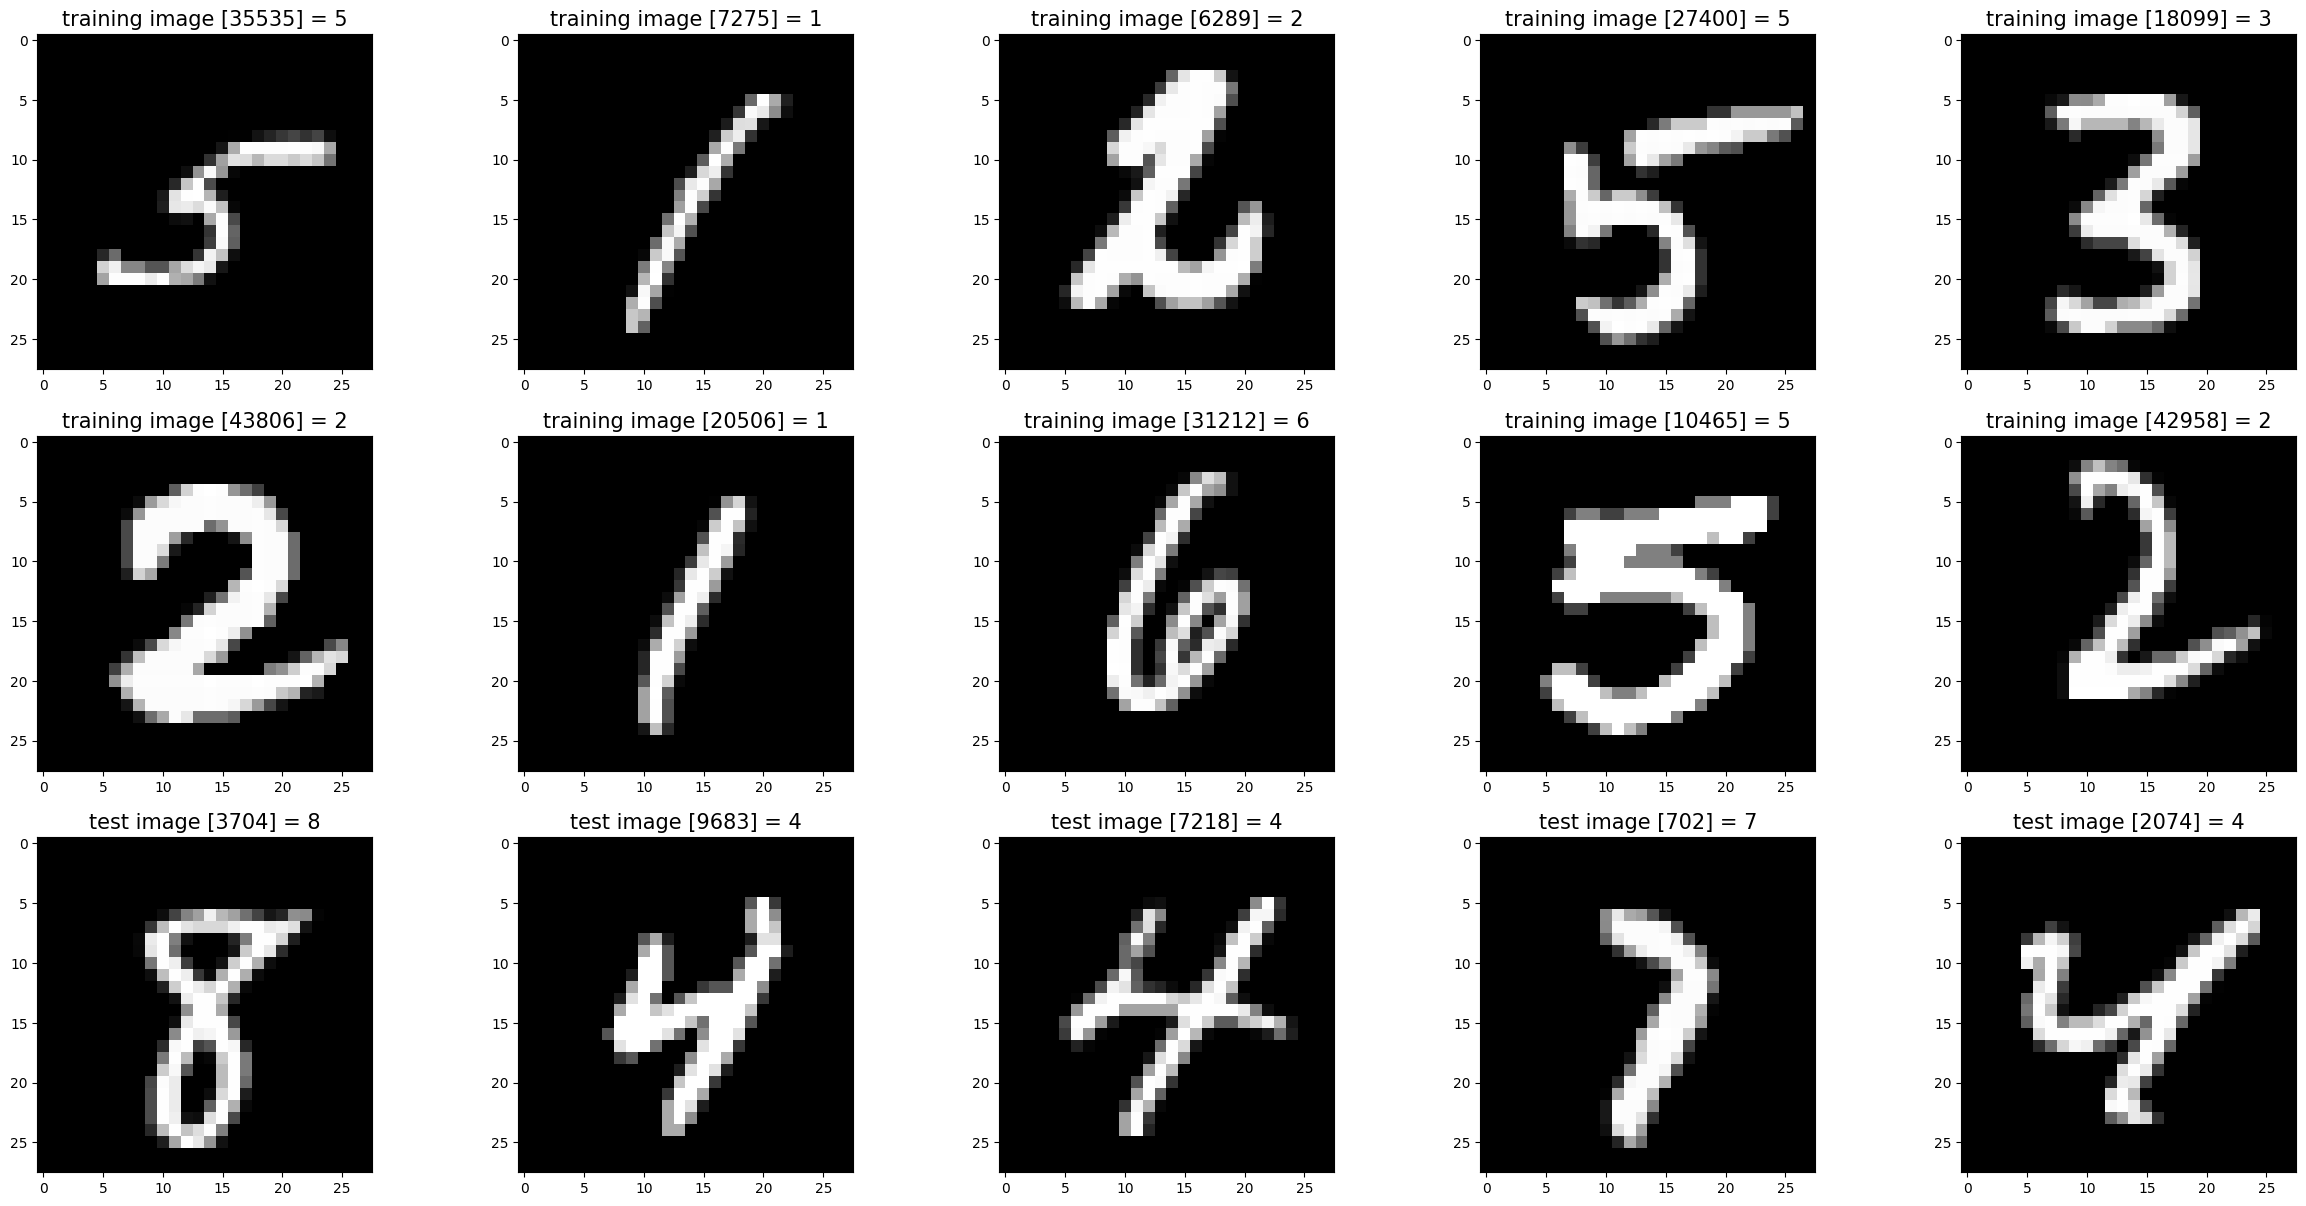

In [19]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [20]:
# Define the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert Python lists to NumPy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Flatten the input images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
x_test_tensor = torch.from_numpy(x_test).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)


In [21]:
# Define a linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the linear classifier
input_size = x_train.shape[1]
num_classes = 10  # MNIST has 10 classes (0-9)
model = LinearClassifier(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create a DataLoader for training data
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [22]:
# Training loop
num_epochs = 10  # You can adjust the number of training epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

# Evaluate the model on the test data10000
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor.float())
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total * 100
    print(f'Accuracy on test data: {accuracy:.2f}%')


Epoch 1/10, Loss: 122.38493189476192
Epoch 2/10, Loss: 102.55044667908886
Epoch 3/10, Loss: 104.9020205184595
Epoch 4/10, Loss: 102.73714587112406
Epoch 5/10, Loss: 102.01215767606234
Epoch 6/10, Loss: 97.72860818411877
Epoch 7/10, Loss: 100.54704743814366
Epoch 8/10, Loss: 98.95807341471918
Epoch 9/10, Loss: 95.66467759578721
Epoch 10/10, Loss: 98.53818271815904
Finished Training
Accuracy on test data: 86.32%


In [23]:
# Define the prediction function
def predict_and_show(model, image, true_label):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert the image to a PyTorch tensor and move it to the appropriate device
    image_tensor = torch.from_numpy(image).to(device)

    # Ensure the image tensor has the correct shape (flatten it)
    image_tensor = image_tensor.view(1, -1).float()

    # Forward pass to get the predicted label
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # Convert the image from a flat array to a 28x28 matrix for display
    image_display = image.reshape(28, 28)

    # Display the image and the predicted label
    plt.figure()
    plt.imshow(image_display, cmap='gray')
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted.item()}')
    plt.show()


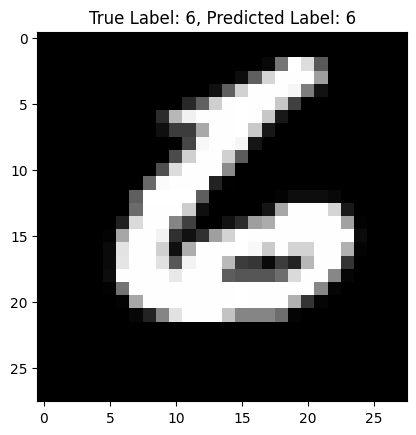

In [24]:
# Example usage
sample_index = 9999  # Replace with the index of the image you want to predict
sample_image = x_test[sample_index]
true_label = y_test[sample_index]

predict_and_show(model, sample_image, true_label)